In [34]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
    	self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
	""" Class for making a forward pass, and getting:
	1. The network output.
	2. Activations from intermeddiate targetted layers.
	3. Gradients from intermeddiate targetted layers. """
	def __init__(self, model, target_layers):
		self.model = model
		self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

	def get_gradients(self):
		return self.feature_extractor.gradients

	def __call__(self, x):
		target_activations, output  = self.feature_extractor(x)
		output = output.view(output.size(0), -1)
		output = self.model.classifier(output)
		return target_activations, output

def preprocess_image(img):
	means=[0.485, 0.456, 0.406]
	stds=[0.229, 0.224, 0.225]

	preprocessed_img = img.copy()[: , :, ::-1]
	for i in range(3):
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
	preprocessed_img = \
		np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
	preprocessed_img = torch.from_numpy(preprocessed_img)
	preprocessed_img.unsqueeze_(0)
	input = Variable(preprocessed_img, requires_grad = True)
	return input

def show_cam_on_image(img, mask):
	heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
	heatmap = np.float32(heatmap) / 255
	cam = heatmap + np.float32(img)
	cam = cam / np.max(cam)
	cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
	def __init__(self, model, target_layer_names, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()

		self.extractor = ModelOutputs(self.model, target_layer_names)

	def forward(self, input):
		return self.model(input) 

	def __call__(self, input, index = None):
		if self.cuda:
			features, output = self.extractor(input.cuda())
		else:
			features, output = self.extractor(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		self.model.features.zero_grad()
		self.model.classifier.zero_grad()
		one_hot.backward(retain_graph=True)

		grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

		target = features[-1]
		target = target.cpu().data.numpy()[0, :]

		weights = np.mean(grads_val, axis = (2, 3))[0, :]
		cam = np.zeros(target.shape[1 : ], dtype = np.float32)

		for i, w in enumerate(weights):
			cam += w * target[i, :, :]

		cam = np.maximum(cam, 0)
		cam = cv2.resize(cam, (224, 224))
		cam = cam - np.min(cam)
		cam = cam / np.max(cam)
		return features, grads_val, cam



def get_args():
	parser = argparse.ArgumentParser()
	parser.add_argument('--use-cuda', action='store_true', default=False,
	                    help='Use NVIDIA GPU acceleration')
	parser.add_argument('--image-path', type=str, default='./examples/both.png',
	                    help='Input image path')
	args = parser.parse_args()
	args.use_cuda = args.use_cuda and torch.cuda.is_available()
	if args.use_cuda:
	    print("Using GPU for acceleration")
	else:
	    print("Using CPU for computation")

	return args



In [35]:
img = cv2.imread('testImg_both.png', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)

In [7]:
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/santhosr/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:16<00:00, 35607568.29it/s]


In [9]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [12]:
for name, module in model.classifier._modules.items():
    print(name)


0
1
2
3
4
5
6


In [36]:
gdcam = GradCam(model, target_layer_names=['35'],use_cuda=True)

In [37]:
target, grads_val,mask = gdcam(input, None)

In [50]:
target = target[0].cpu().data.numpy()[0, :]

In [45]:
weights = np.mean(grads_val, axis = (2, 3))[0, :]

In [52]:
for i, w in enumerate(weights):
    cam += w * target[i, :, :]

NameError: name 'cam' is not defined

In [54]:
target.shape

(512, 14, 14)

In [21]:
import matplotlib.pyplot as plt

In [22]:
%matplotlib inline

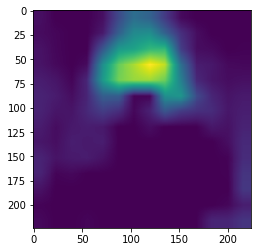

In [23]:
plt.imshow(mask)

In [25]:
gdcam.extractor.get_gradients()[0].shape

torch.Size([1, 512, 14, 14])

In [26]:
grads_val = gdcam.extractor.get_gradients()[-1].cpu().data.numpy()

In [28]:
grads_val.shape

(1, 512, 14, 14)